# Single Cell ATAC Sequencing

This is a sequencing method that allows us to find regions of chromatin that are not condensed or wound around histone proteins. In other words, these regions are available to bind with DNA binding proteins.

The data obtained from a single cell ATAC seq experiment can be analysed with the `Signac` and `Seurat` packages in R. A demonstration has been provided in this notebook, using a dataset of human peripheral blood mono-nuclear cells provided by [10x Genomics](https://www.10xgenomics.com/).

In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.19")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion'

Old packages: 'gert', 'rstudioapi'



In [2]:
BiocManager::install(c("EnsDb.Hsapiens.v75", "biovizBase"))
remotes::install_github("stuart-lab/signac", ref = "develop")
install.packages(c("Seurat", "Matrix", "irlba", "hdf5r"), type = "source")

library(Signac)
library(Seurat)
library(EnsDb.Hsapiens.v75)
library(biovizBase)
library(tidyverse)
library(hdf5r)
library(Matrix)
library(irlba)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'EnsDb.Hsapiens.v75', 'biovizBase'

also installing the dependencies ‘formatR’, ‘RCurl’, ‘rjson’, ‘lambda.r’, ‘futile.options’, ‘plogr’, ‘XML’, ‘BiocIO’, ‘restfulr’, ‘checkmate’, ‘matrixStats’, ‘abind’, ‘SparseArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘png’, ‘RSQLite’, ‘Biobase’, ‘rtracklayer’, ‘ProtGenerics’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘Formula’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘XVector’, ‘MatrixGenerics’, ‘S4Arrays’, ‘DelayedArray’, ‘zlibbioc’, ‘bitops’, ‘BiocParallel’, ‘Rhtslib’, ‘KEGGREST’, ‘BSgenome’, ‘lazyeval’, ‘ensembldb’, ‘Hmisc’, ‘dichromat’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘GenomeInfoDb’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘Biostrings’, ‘Rsamtools’, ‘GenomicAlignments’, ‘

parallelly   (NA -> 1.38.0   ) [CRAN]
listenv      (NA -> 0.9.1    ) [CRAN]
globals      (NA -> 0.16.3   ) [CRAN]
dotCall64    (NA -> 1.2      ) [CRAN]
future       (NA -> 1.34.0   ) [CRAN]
RcppEigen    (NA -> 0.3.4.0.2) [CRAN]
spam         (NA -> 2.11-0   ) [CRAN]
progressr    (NA -> 0.14.0   ) [CRAN]
future.apply (NA -> 1.11.2   ) [CRAN]
sp           (NA -> 2.1-4    ) [CRAN]
RcppRoll     (NA -> 0.3.1    ) [CRAN]
fastmatch    (NA -> 1.1-4    ) [CRAN]
patchwork    (NA -> 1.3.0    ) [CRAN]
pbapply      (NA -> 1.7-2    ) [CRAN]
irlba        (NA -> 2.3.5.1  ) [CRAN]
SeuratObject (NA -> 5.0.2    ) [CRAN]


Skipping 6 packages not available: BiocGenerics, S4Vectors, Rsamtools, IRanges, GenomicRanges, GenomeInfoDb

Installing 16 packages: parallelly, listenv, globals, dotCall64, future, RcppEigen, spam, progressr, future.apply, sp, RcppRoll, fastmatch, patchwork, pbapply, irlba, SeuratObject

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpyp9Y74/remotes42030409b93/stuart-lab-signac-0b33b11/DESCRIPTION’ ... OK
* preparing ‘Signac’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Removed empty directory ‘Signac/.github’
Removed empty directory ‘Signac/pkgdown’
Removed empty directory ‘Signac/vignettes’
* building ‘Signac_1.14.0.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘caTools’, ‘plyr’, ‘tensor’, ‘sitmo’, ‘zoo’, ‘crosstalk’, ‘RcppTOML’, ‘here’, ‘gplots’, ‘reshape2’, ‘RcppArmadillo’, ‘spatstat.data’, ‘spatstat.univar’, ‘spatstat.random’, ‘spatstat.utils’, ‘spatstat.sparse’, ‘goftest’, ‘deldir’, ‘polyclip’, ‘FNN’, ‘dqrng’, ‘cowplot’, ‘fastDummies’, ‘fitdistrplus’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘leiden’, ‘lmtest’, ‘plotly’, ‘RANN’, ‘RcppAnnoy’, ‘RcppHNSW’, ‘reticulate’, ‘ROCR’, ‘RSpectra’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘spatstat.explore’, ‘spatstat.geom’, ‘uwot’, ‘RcppProgress’


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: ensembldb

Loading required package: BiocGene

In [3]:
system("wget https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_Controller/10k_pbmc_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.h5")
system("wget https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_Controller/10k_pbmc_ATACv2_nextgem_Chromium_Controller_singlecell.csv")
system("wget https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_Controller/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fragments.tsv.gz")
system("wget https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_Controller/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fragments.tsv.gz.tbi")

## Preprocessing

The first step in the workflow is to read in and preprocess the data. This is done by creating a `Seurat` object and adding gene annotations to it.

In [4]:
# The fragment file contains all unique fragments from each single cell.

frag.file <- read.delim("/content/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fragments.tsv.gz", header = F, nrows = 10)
head(frag.file)

,V1
,<chr>
1,# id=10k_pbmc_ATACv2_nextgem_Chromium_Controller
2,# description=Human PBMCs
3,#
4,# pipeline_name=cellranger-atac
5,# pipeline_version=cellranger-atac-2.1.0
6,#


In [5]:
# The rows of the counts matrix contain the regions on the chromosome that are unwound.

counts <- Read10X_h5("/content/10k_pbmc_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.h5")
counts[1:10, 1:10]

  [[ suppressing 10 column names 'AAACGAAAGAGAGGTA-1', 'AAACGAAAGCAGGAGG-1', 'AAACGAAAGGAAGAAC-1' ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                                      
chr1:9772-10660    . . . . . . . . . .
chr1:180712-181178 . . . . . . . . . .
chr1:181200-181607 . . . . . . . . . .
chr1:191183-192084 . . . . . . . . . .
chr1:267576-268461 . . . . . . . . . .
chr1:270850-271755 . . . . . . . . . .
chr1:273946-274792 . . . . . . . . . .
chr1:585753-586648 . . . . . . . . . .
chr1:605079-605959 . . . . . . . . . .
chr1:629538-630397 . . . . . . . . 2 .

In [6]:
# Both of the files mentioned previously are used to create a chromatin assay.
# This allows the use of pecialised functions to analyse single-cell genomic data.

chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  fragments = "/content/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fragments.tsv.gz",
  min.cells = 10,
  min.features = 200
)

Computing hash



In [7]:
str(chrom_assay)

Formal class 'ChromatinAssay' [package "Signac"] with 16 slots
  ..@ ranges            :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. ..@ values         : Factor w/ 35 levels "chr1","chr2",..: 1 10 11 12 13 14 15 16 17 18 ...
  .. .. .. .. ..@ lengths        : int [1:35] 15868 7958 7791 8494 4196 5442 5358 5235 7519 3407 ...
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. .. .. ..@ start          : int [1:165434] 9772 180712 181200 191183 267576 270850 273946 585753 605079 629538 ...
  .. .. .. .. ..@ width          : int [1:165434] 889 467 408 902 886 906 847 896 881 860 ...
  .. .. .. .. ..@ NAMES          : NULL
  .. .. .. .. ..@ elementType    : chr "ANY"
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ 

In [8]:
# The metadata contains essential information about the data

metadata <- read.csv("/content/10k_pbmc_ATACv2_nextgem_Chromium_Controller_singlecell.csv", header = T, row.names = 1)
View(metadata)

,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,nonprimary,passed_filters,is__cell_barcode,excluded_reason,TSS_fragments,DNase_sensitive_region_fragments,enhancer_region_fragments,promoter_region_fragments,on_target_fragments,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
NO_BARCODE,20081988,3972351,3423,2118408,1159348,23059,4131,12801268,0,0,0,0,0,0,0,0,0,0
AAACGAAAGAAACGCC-1,4,0,0,0,0,0,0,4,0,0,1,0,0,0,1,0,2,4
AAACGAAAGAAAGCAG-1,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,2
AAACGAAAGAAAGGGT-1,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,2
AAACGAAAGAAATACC-1,17,0,0,0,0,0,0,17,0,0,11,0,0,0,11,0,14,27
AAACGAAAGAAATCTG-1,1,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0
AAACGAAAGAAATGGG-1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACGAAAGAAATTCG-1,4,0,0,0,1,0,0,3,0,0,1,0,0,0,1,0,2,4
AAACGAAAGAACAGGA-1,2,0,0,0,0,0,0,2,0,0,2,0,0,0,2,0,2,4


In [9]:
# The metadata and the chromatin assay are used to create the Seurat object.

pbmc <- CreateSeuratObject(
  counts = chrom_assay,
  meta.data = metadata,
  assay = "ATAC"
)

str(pbmc)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ ATAC:Formal class 'ChromatinAssay' [package "Signac"] with 16 slots
  .. .. .. ..@ ranges            :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. .. .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. .. .. .. ..@ values         : Factor w/ 35 levels "chr1","chr2",..: 1 10 11 12 13 14 15 16 17 18 ...
  .. .. .. .. .. .. .. ..@ lengths        : int [1:35] 15868 7958 7791 8494 4196 5442 5358 5235 7519 3407 ...
  .. .. .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. .. .. .. ..@ metadata       : list()
  .. .. .. .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. .. .. .. .. .. ..@ start          : int [1:165434] 9772 180712 181200 191183 267576 270850 273946 585753 605079 629538 ...
  .. .. .. .. .. .. .. ..@ width          : int [1:165434] 889 467 408 902 886 906 847 896 881 86

In [10]:
#There are currently no added annotations, so this track will be empty.
pbmc$ATAC$annotation

NULL

In [11]:
# We can add gene annotations for the human genome.
# This will allow downstream functions to obtain the gene annotation information directly from the Seurat object.

annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)
annotations

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

GRanges object with 3072120 ranges and 5 metadata columns:
                  seqnames        ranges strand |           tx_id   gene_name
                     <Rle>     <IRanges>  <Rle> |     <character> <character>
  ENSE00001489430        X 192989-193061      + | ENST00000399012      PLCXD1
  ENSE00001536003        X 192991-193061      + | ENST00000484611      PLCXD1
  ENSE00002160563        X 193020-193061      + | ENST00000430923      PLCXD1
  ENSE00001750899        X 197722-197788      + | ENST00000445062      PLCXD1
  ENSE00001489388        X 197859-198351      + | ENST00000381657      PLCXD1
              ...      ...           ...    ... .             ...         ...
  ENST00000361739       MT     7586-8269      + | ENST00000361739      MT-CO2
  ENST00000361789       MT   14747-15887      + | ENST00000361789      MT-CYB
  ENST00000361851       MT     8366-8572      + | ENST00000361851     MT-ATP8
  ENST00000361899       MT     8527-9207      + | ENST00000361899     MT-ATP6
  ENS

In [12]:
seqlevels(annotations) <- paste("chr", seqlevels(annotations))

In [13]:
Annotation(pbmc) <- annotations

In [14]:
#The annotations from the Ensembl Database have been added.
pbmc$ATAC$annotation

GRanges object with 3072120 ranges and 5 metadata columns:
                  seqnames        ranges strand |           tx_id   gene_name
                     <Rle>     <IRanges>  <Rle> |     <character> <character>
  ENSE00001489430    chr X 192989-193061      + | ENST00000399012      PLCXD1
  ENSE00001536003    chr X 192991-193061      + | ENST00000484611      PLCXD1
  ENSE00002160563    chr X 193020-193061      + | ENST00000430923      PLCXD1
  ENSE00001750899    chr X 197722-197788      + | ENST00000445062      PLCXD1
  ENSE00001489388    chr X 197859-198351      + | ENST00000381657      PLCXD1
              ...      ...           ...    ... .             ...         ...
  ENST00000361739   chr MT     7586-8269      + | ENST00000361739      MT-CO2
  ENST00000361789   chr MT   14747-15887      + | ENST00000361789      MT-CYB
  ENST00000361851   chr MT     8366-8572      + | ENST00000361851     MT-ATP8
  ENST00000361899   chr MT     8527-9207      + | ENST00000361899     MT-ATP6
  ENS

##Quality Control

There are five metrics that are considered for quality control of scATAC-seq data:

1. Nucleosome signal and nucleosome banding pattern
2. Transcription Start Site (TSS) Enrichment
3. Total number of fragments in peaks
4. Fraction of fragments in peaks
5. Ratio reads in genomic blacklist regions

These metrics will be examined in detail along with the code used to perform quality control.

In [15]:
# 1. Nucleosome Signal
# The primary goal of scATAC-seq is to detect regions of unwound DNA, where DNA binding proteins are free to bind.
# The signal helps us to detect regions of DNA that are condensed into nucleosomes and thus cannot bind to DNA binding proteins.

pbmc <- NucleosomeSignal(pbmc)

In [16]:
#2. TSS Enrichment
# DNA that is unwound is available to be transcribed.
# Therefore, we are interested in locating peaks found on the transcription start sites of the DNA.

pbmc <- TSSEnrichment(object = pbmc)

Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



In [17]:
#3. Blacklist Ratio
# This metric helps us to locate and exclude certain regions of DNA that pose problems for high-throughput sequencing analyses.
# These regions include unstructured or repetitive regions.

pbmc$blacklist_ratio <- pbmc$blacklist_region_fragments / pbmc$peak_region_fragments

In [18]:
#4. Fraction of Reads in Peaks
# Peaks with low fractions of reads are considered of low quality and should be filtered out.
# Generally, peaks with < 15-20% reads are filtered out.

pbmc$fraction_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100

In [19]:
View(pbmc@meta.data)

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,nonprimary,⋯,on_target_fragments,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,blacklist_ratio,fraction_reads_in_peaks
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACGAAAGAGAGGTA-1,SeuratProject,32618,12605,59781,33159,1,633,3228,221,17,⋯,9962,0,17067,32618,0.5054022,0.06,0,1,0,75.77924
AAACGAAAGCAGGAGG-1,SeuratProject,13293,5392,19399,9003,1,231,1137,2,3,⋯,5362,0,6888,13293,0.4906667,0.04,0,1,0,76.34671
AAACGAAAGGAAGAAC-1,SeuratProject,36155,13306,64452,31013,4,549,4538,182,4,⋯,13887,0,19132,36155,0.6323430,0.40,0,1,0,67.93552
AAACGAAAGTCGACCC-1,SeuratProject,40155,14049,72316,38705,5,622,3831,11,6,⋯,15159,0,21185,40155,0.6112150,0.32,0,1,0,72.71074
AAACGAACAAGCACTT-1,SeuratProject,18998,7115,32569,16889,7,343,2108,89,5,⋯,7542,0,9841,18998,0.4175417,0.01,0,1,0,74.96191
AAACGAACAAGCGGTA-1,SeuratProject,39218,14514,81259,40822,3,800,5299,15,15,⋯,15157,0,20945,39218,0.8787062,0.93,0,1,0,61.05524
AAACGAACACATAAAG-1,SeuratProject,79111,24477,132874,67735,18,1232,6819,241,3,⋯,25562,0,41716,79111,0.6204149,0.35,0,1,0,73.41006
AAACGAACACATATCG-1,SeuratProject,27594,10617,44777,20368,2,479,2711,188,7,⋯,10994,0,14582,27594,0.6431588,0.44,0,1,0,69.36543
AAACGAACACCCTTTG-1,SeuratProject,27453,10830,41932,18806,12,423,2737,570,2,⋯,9877,0,14388,27453,0.4424163,0.02,0,1,0,74.23383


In [20]:
# Visualising the Quality Control Metrics helps us decide our cut-off thresholds.

colnames(pbmc@meta.data)
a1 <- DensityScatter(pbmc, x = "nCount_ATAC", y = "TSS.enrichment", log_x = TRUE, quantiles = TRUE)

[1] "orig.ident"                       "nCount_ATAC"                     
 [3] "nFeature_ATAC"                    "total"                           
 [5] "duplicate"                        "chimeric"                        
 [7] "unmapped"                         "lowmapq"                         
 [9] "mitochondrial"                    "nonprimary"                      
[11] "passed_filters"                   "is__cell_barcode"                
[13] "excluded_reason"                  "TSS_fragments"                   
[15] "DNase_sensitive_region_fragments" "enhancer_region_fragments"       
[17] "promoter_region_fragments"        "on_target_fragments"             
[19] "blacklist_region_fragments"       "peak_region_fragments"           
[21] "peak_region_cutsites"             "nucleosome_signal"               
[23] "nucleosome_percentile"            "TSS.enrichment"                  
[25] "TSS.percentile"                   "blacklist_ratio"                 
[27] "fraction_reads_in_peaks"

In [21]:
a2 <- DensityScatter(pbmc, x = 'nucleosome_signal', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)

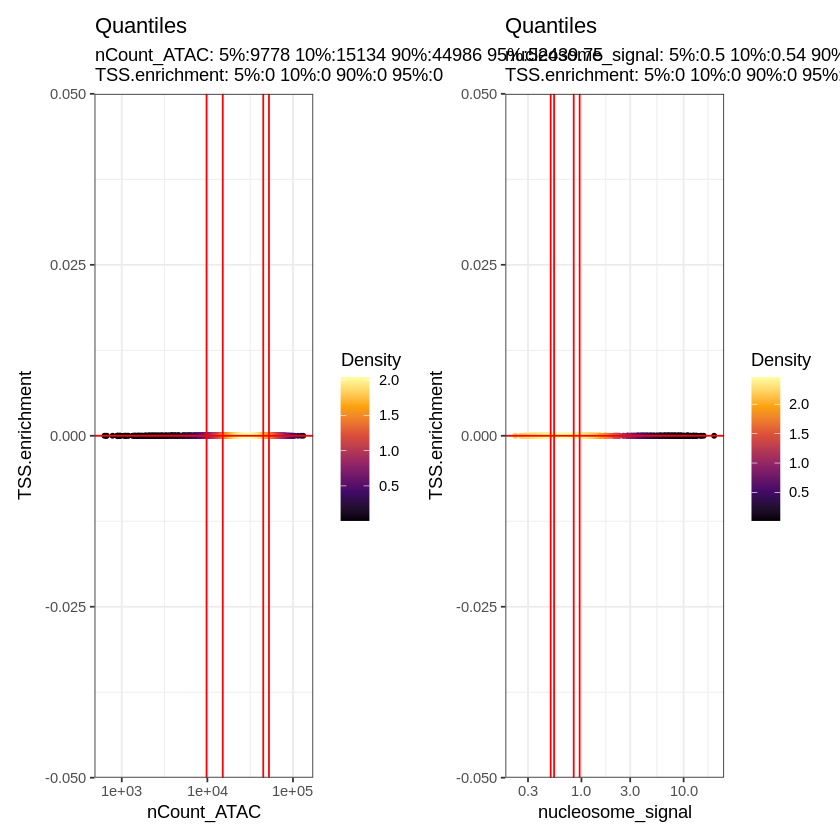

In [22]:
a1 | a2

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of TSS.enrichment."
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of blacklist_ratio."


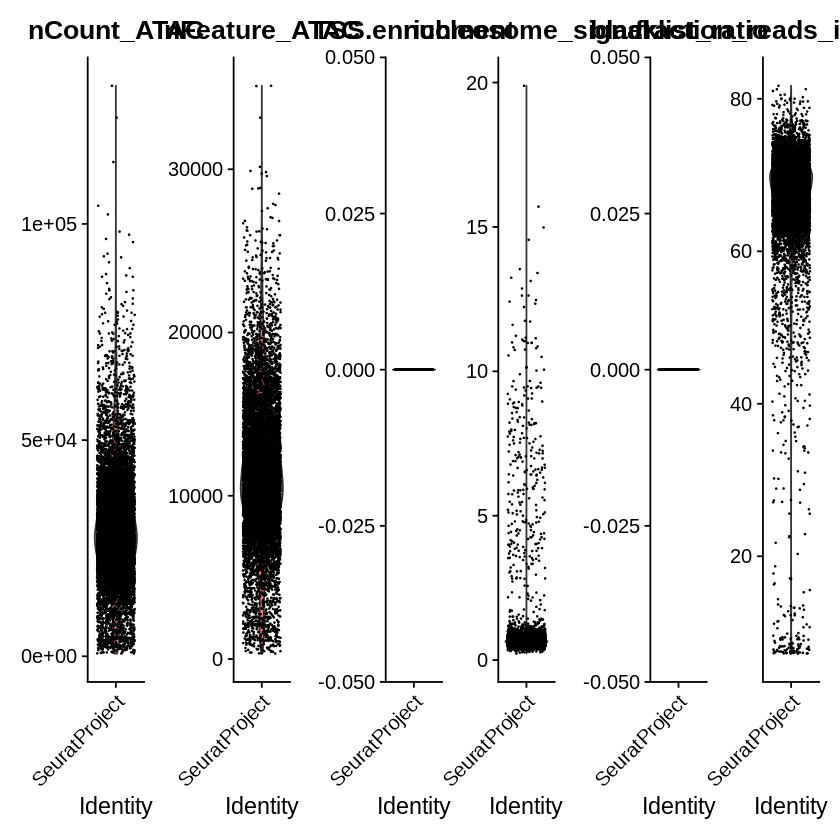

In [23]:
VlnPlot(object = pbmc,
                features = c("nCount_ATAC", "nFeature_ATAC", "TSS.enrichment", "nucleosome_signal", "blacklist_ratio", "fraction_reads_in_peaks"),
                pt.size = 0.1,
                ncol = 6)

In [25]:
# Filtering out low quality cells according to our selected thresholds.
pbmc <- subset(x = pbmc,
                subset = nCount_ATAC > 3000 |
                  fraction_reads_in_peaks > 15 |
                  blacklist_ratio < 0.05 |
                  nucleosome_signal < 4 |
                  TSS.enrichment > 3)

In [27]:
#Normalisation for differences in cellular sequencing depth across cells and peaks

pbmc <- RunTFIDF(pbmc)
pbmc <- FindTopFeatures(pbmc, min.cutoff = 'q0') #selecting top features
pbmc <- RunSVD(pbmc) #Dimensionality reduction

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x09 in encoding latin1"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x09 in encoding latin1"


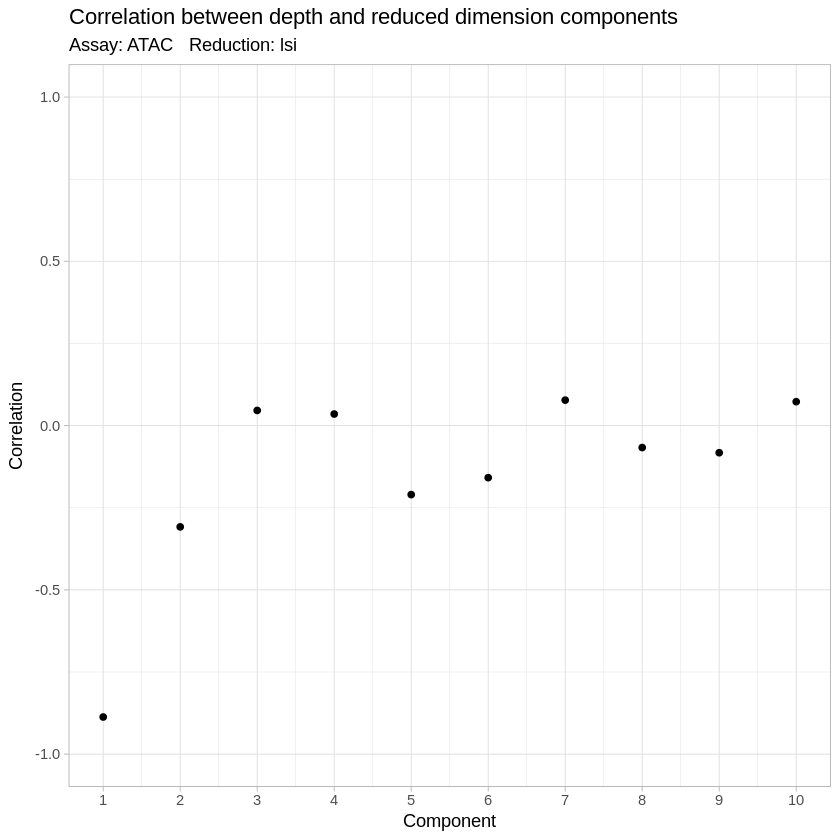

In [28]:
DepthCor(pbmc) #correlates sequencing depth with reduced dimensions

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
08:34:19 UMAP embedding parameters a = 0.9922 b = 1.112

08:34:19 Read 10246 rows and found 29 numeric columns

08:34:19 Using Annoy for neighbor search, n_neighbors = 30

08:34:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

08:34:21 Writing NN index file to temp file /tmp/Rtmpyp9Y74/file4204e41a3aa

08:34:21 Searching Annoy index using 1 thread, search_k = 3000

08:34:24 Annoy recall = 100%

08:34:25 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10246
Number of edges: 376377

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.8924
Number of communities: 20
Elapsed time: 5 seconds


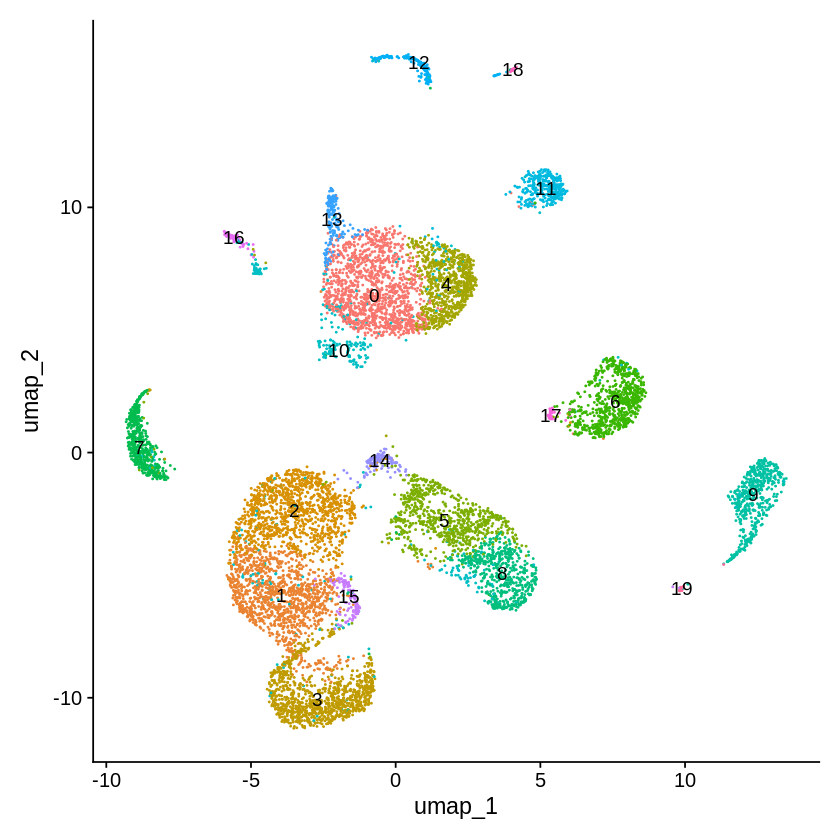

In [29]:
# Clustering

pbmc <- RunUMAP(object = pbmc, reduction = 'lsi', dims = 2:30) #The first component is excluded as it captures the technical variation
pbmc <- FindNeighbors(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindClusters(object = pbmc, algorithm = 3)

#Visualise the data
DimPlot(object = pbmc, label = TRUE) + NoLegend()